<a href="https://colab.research.google.com/github/Papa-Panda/random_thoughts/blob/main/foreground_mask_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# test reading a file, successful
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
# df0=pd.read_csv('drive/My Drive/nimbus/Data_tabs_by_date.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
from IPython.display import display
import torch
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image


In [53]:
# test opening a image file, successful
path_to_image_1 = 'drive/My Drive/foreground_prediction/fg/img84.jpg'


img = Image.open(path_to_image_1)

# Display basic information about the image
print("Image Format:", img.format)
print("Image Mode:", img.mode)
print("Image Size:", img.size)
# display(img)

Image Format: JPEG
Image Mode: RGB
Image Size: (790, 687)


In [54]:
from torchvision.transforms import Resize

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image


In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Down-sampling path
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Up-sampling path
        self.upconv1 = nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)

    def forward(self, x):
        # Down-sampling
        x = F.relu(self.conv1(x))
        x_down = self.maxpool(x)

        # Up-sampling
        x_up = self.upconv1(x_down)

        return x_up

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()

#         # Down-sampling path
#         self.down_conv1 = self.conv_block(3, 64)
#         self.down_conv2 = self.conv_block(64, 128)
#         self.down_conv3 = self.conv_block(128, 256)
#         self.down_conv4 = self.conv_block(256, 512)

#         # Up-sampling path
#         self.up_conv4 = self.conv_block(512, 256)
#         self.up_conv3 = self.conv_block(256, 128)
#         self.up_conv2 = self.conv_block(128, 64)

#         # Final convolution
#         self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

#     def conv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         # Down-sampling
#         down1 = self.down_conv1(x)
#         down1_pool = F.max_pool2d(down1, kernel_size=2, stride=2)
#         down2 = self.down_conv2(down1_pool)
#         down2_pool = F.max_pool2d(down2, kernel_size=2, stride=2)
#         down3 = self.down_conv3(down2_pool)
#         down3_pool = F.max_pool2d(down3, kernel_size=2, stride=2)
#         down4 = self.down_conv4(down3_pool)
#         down4_pool = F.max_pool2d(down4, kernel_size=2, stride=2)
#         print('Down-sampling ' * 10 )

#         # Up-sampling
#         up4 = F.interpolate(down4_pool, scale_factor=2, mode='bilinear', align_corners=True)
#         up4 = torch.cat([down3, up4], dim=1)
#         up4 = self.up_conv4(up4)
#         up3 = F.interpolate(up4, scale_factor=2, mode='bilinear', align_corners=True)
#         up3 = torch.cat([down2, up3], dim=1)
#         up3 = self.up_conv3(up3)
#         up2 = F.interpolate(up3, scale_factor=2, mode='bilinear', align_corners=True)
#         up2 = torch.cat([down1, up2], dim=1)
#         up2 = self.up_conv2(up2)


#         # Final convolution
#         output = self.final_conv(up2)
#         output = torch.sigmoid(output)  # Apply sigmoid activation for binary classification

#         return output


In [128]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, target_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        # Resize images and masks to the target size
        image = Resize(self.target_size)(image)
        mask = Resize(self.target_size, interpolation=Image.NEAREST)(mask)
        display(image)
        display(mask)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        print(image)
        print(mask)

        return image, mask

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        smooth = 1e-6
        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()
        dice = (2.0 * intersection + smooth) / (union + smooth)
        loss = 1 - dice
        return loss

# Example paths to images and masks
# image_paths = ["path_to_image_1.jpg", "path_to_image_2.jpg", ...]
image_paths = [ 'drive/My Drive/foreground_prediction/fg/img'+str(i)+'.jpg' for i in range(292)]
# mask_paths = ["path_to_mask_1.jpg", "path_to_mask_2.jpg", ...]
mask_paths = [ 'drive/My Drive/foreground_prediction/fg/mask'+str(i)+'.jpg' for i in range(292)]

# Create custom dataset
dataset = CustomDataset(image_paths, mask_paths, transform=ToTensor())

# Define data loader
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = UNet()
# criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [114]:
|# dataset

In [115]:
# check image size

In [116]:
model

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv1): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [130]:

# Train the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in tqdm(data_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images = images.to(device)
        masks = masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        # print(outputs)
        # print(masks)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for the epoch
    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")

# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')

Epoch 1/10: 100%|██████████| 73/73 [02:03<00:00,  1.69s/it]


Epoch 1/10, Loss: 0.13938180255155042


Epoch 2/10: 100%|██████████| 73/73 [00:30<00:00,  2.43it/s]


Epoch 2/10, Loss: 0.08460907112449816


Epoch 3/10: 100%|██████████| 73/73 [00:30<00:00,  2.42it/s]


Epoch 3/10, Loss: 0.06263983979412954


Epoch 4/10: 100%|██████████| 73/73 [00:34<00:00,  2.12it/s]


Epoch 4/10, Loss: 0.05388386596045266


Epoch 5/10: 100%|██████████| 73/73 [00:33<00:00,  2.20it/s]


Epoch 5/10, Loss: 0.05377938575430276


Epoch 6/10: 100%|██████████| 73/73 [00:32<00:00,  2.21it/s]


Epoch 6/10, Loss: 0.05184291989529786


Epoch 7/10: 100%|██████████| 73/73 [00:30<00:00,  2.40it/s]


Epoch 7/10, Loss: 0.05071383058922748


Epoch 8/10: 100%|██████████| 73/73 [00:30<00:00,  2.43it/s]


Epoch 8/10, Loss: 0.04899955571514286


Epoch 9/10: 100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


Epoch 9/10, Loss: 0.04776650646778002


Epoch 10/10: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s]

Epoch 10/10, Loss: 0.04813936079711947


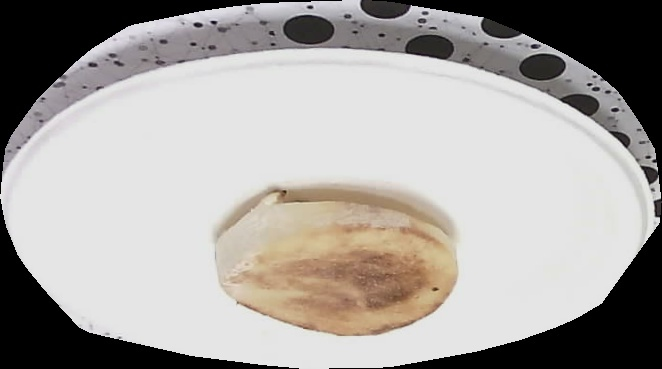

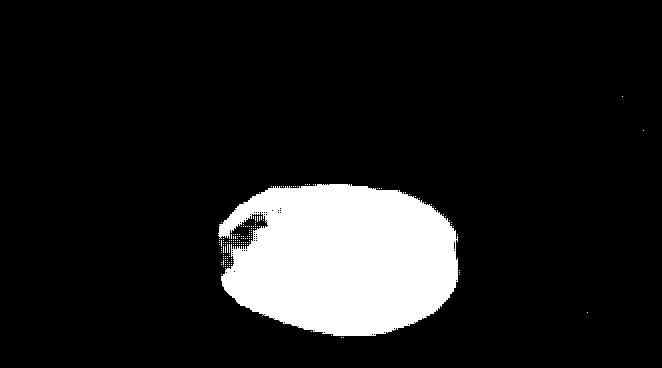

In [141]:

# Load the trained model
model = UNet()
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Define the transform to convert PIL image to tensor
transform = ToTensor()

# Load and preprocess the image
pick_index = 90
image_path = image_paths[pick_index]
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(image_tensor)

# Post-process the output
output_binary = (output > 0.5).float()  # Convert probabilities to binary values (0 or 1)

# Convert the tensor back to PIL image
output_image = ToPILImage()(output_binary.squeeze(0))

display(image)
display( output_image )

In [131]:
# problem 1
# # image size input are slighlty different
# # need to normalize
# # image_paths = [ 'drive/My Drive/foreground_prediction/fg/img'+str(i)+'.jpg' for i in range(292)]
# # # mask_paths = ["path_to_mask_1.jpg", "path_to_mask_2.jpg", ...]
# # mask_paths = [ 'drive/My Drive/foreground_prediction/fg/mask'+str(i)+'.jpg' for i in range(292)]
# # path_to_image_1 = 'drive/My Drive/foreground_prediction/fg/img84.jpg'

# for i in range(20):

#   img = Image.open(image_paths[i])
#   print("Image Size:", img.size)
#   img = Image.open(mask_paths[i])
#   print("Image Size:", img.size)


#2 problem 2
# model does not work
# solution: use a simplified model to show feasibility


#3  problem 3
# image and masks in the net is always 0 for some reason
# double checked the data by display(image), the image is read well